In [469]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [345]:
%matplotlib inline

In [346]:
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

In [505]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загрузим данные и создадим датафрейм df

In [347]:
DATASET_PATH = './orders_20190822.csv'
#PREPARED_DATASET_PATH = './data_prepared.csv'

df = pd.read_csv(DATASET_PATH, sep=';')
df.head(3)

,id_o,user_id,price,o_date
0,1234491,337544,"539,000",01.01.2016
1,1234494,171642,"153,300",01.01.2016
2,1234497,260596,"55,300",01.01.2016


Проверим тип данных

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002804 entries, 0 to 2002803
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id_o     int64 
 1   user_id  int64 
 2   price    object
 3   o_date   object
dtypes: int64(2), object(2)
memory usage: 61.1+ MB


Перекодируем переменную price в числовой, перед этим заменив запятую на точку

In [349]:
df['price'] = df['price'].str.replace(',','.')
df.head(3)

,id_o,user_id,price,o_date
0,1234491,337544,539.000,01.01.2016
1,1234494,171642,153.300,01.01.2016
2,1234497,260596,55.300,01.01.2016


In [350]:
df['price'] = pd.to_numeric(df['price'])

И преобразуем столбец "Дата" в дату

In [351]:
df['o_date'] = pd.to_datetime(df['o_date'])

In [352]:
df.dtypes

id_o                int64
user_id             int64
price             float64
o_date     datetime64[ns]
dtype: object

<h2> Переходим к анализу переменых

In [353]:
target = 'price'

In [354]:
target_mean = round(df[target].mean(), 2)
target_median = df[target].median()
target_mode = df[target].mode()[0]

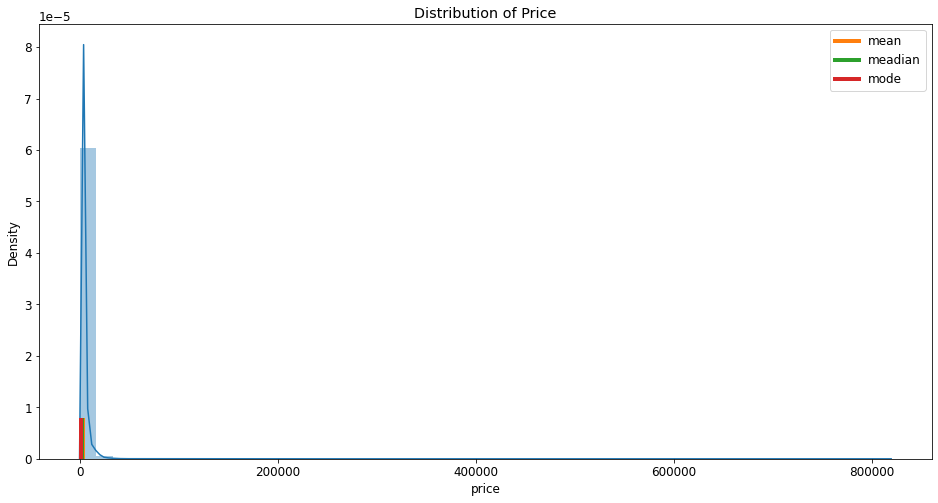

In [261]:
plt.figure(figsize = (16, 8))

sns.distplot(df[target], bins=50)

y = np.linspace(0, 0.0000075, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='meadian',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Не самое красивое распределение, глянем выбросы

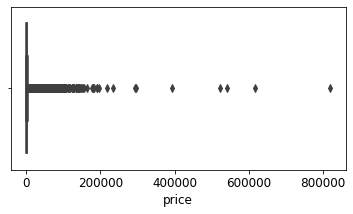

In [262]:
plt.figure(figsize=(6, 3))

sns.boxplot(df[target], whis=1.5)

plt.xlabel(target)
plt.show()

In [355]:
df.loc[df[target] >= 150000].sort_values('user_id')

,id_o,user_id,price,o_date
790430,3303901,201760,219345.0,2016-12-14
78684,1406908,1112710,163480.1,2016-02-21
645915,2847148,1228381,179391.8,2016-09-11
343490,2023104,1658838,156863.0,2016-07-07
375564,2116731,1721394,296153.2,2016-07-23
392370,2166729,1746894,180236.0,2016-01-08
498952,2456333,1959313,616994.0,2016-09-19
524436,2524864,2004224,819096.6,2016-09-29
735905,3126046,2488786,294086.8,2016-01-12
886816,3610029,2908641,191030.0,2017-01-14


Случайные огромные покупки. Причем не сказать, что это какой-то оптовик, каждый раз от разных людей. Попробуем заменить медианой и глянем на распределение

In [356]:
df.loc[df[target] >= 150000, [target]] = target_median

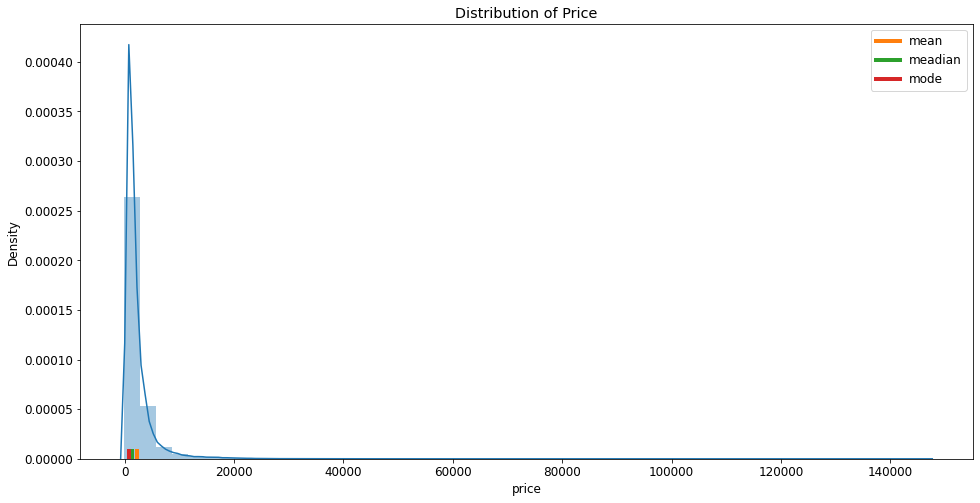

In [265]:
plt.figure(figsize = (16, 8))

sns.distplot(df[target], bins=50)

y = np.linspace(0, 0.0000075, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='meadian',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

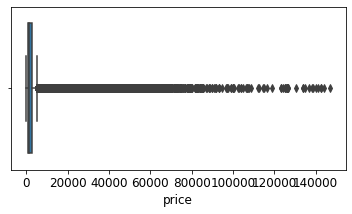

In [266]:
plt.figure(figsize=(6, 3))

sns.boxplot(df[target], whis=1.5)

plt.xlabel(target)
plt.show()

Уже интересней и логичнее

In [357]:
df.loc[df[target] >= 100000]

,id_o,user_id,price,o_date
12280,1261684,1112710,100688.0,2016-11-01
53383,1351585,1197628,138379.5,2016-04-02
174860,1610185,1391257,147140.0,2016-12-04
302198,1912326,1588755,107470.3,2016-06-16
349989,2042349,1229488,144179.0,2016-10-07
363678,2082732,1700637,126599.2,2016-07-18
363710,2082828,1700637,141051.4,2016-07-18
363955,2083557,1701306,112324.1,2016-07-18
378634,2125887,638725,116340.7,2016-07-25
432698,2279955,1825293,125688.5,2016-08-21


<h3> Глянем пропуски

In [358]:
df.isna().sum()

id_o       0
user_id    0
price      0
o_date     0
dtype: int64

Теперь отберем данные которые нам требуются для задачи: прогноз ТО на 05.2017 <br>
То есть все что больше 01.06.2017 нам не надо

In [359]:
df.loc[df['o_date'] >= '2017-06-01']

,id_o,user_id,price,o_date
867098,3548007,1587273,441.7,2017-06-01
867101,3548013,1587273,565.6,2017-06-01
867102,3548014,2857708,3880.8,2017-06-01
867104,3548019,2857695,5.6,2017-06-01
867105,3548020,2857696,853.3,2017-06-01
...,...,...,...,...
2002799,6945524,5806002,825.3,2017-12-31
2002800,6945526,5919142,4934.3,2017-12-31
2002801,6945527,1574166,804.3,2017-12-31
2002802,6945528,5919156,5019.7,2017-12-31


In [361]:
df = df.drop(np.where(df['o_date'] >= '2017-06-01')[0])

In [362]:
df.loc[df['o_date'] >= '2017-06-01']

,id_o,user_id,price,o_date


Выберем весь май в отдельный df

In [363]:
df_may = df.loc[df['o_date'] >= '2017-05-01']
df_may.head()

,id_o,user_id,price,o_date
865745,3543674,1244212,4046.0,2017-05-01
865746,3543675,2853585,135.8,2017-05-01
865747,3543676,540972,1129.1,2017-05-01
865749,3543681,2853591,601.3,2017-05-01
865750,3543682,296335,1013.6,2017-05-01


In [364]:
df = df.loc[df['o_date'] < '2017-05-01']

In [365]:
df.loc[df['o_date'] >= '2017-05-01']

,id_o,user_id,price,o_date


In [366]:
df

,id_o,user_id,price,o_date
0,1234491,337544,539.0,2016-01-01
1,1234494,171642,153.3,2016-01-01
2,1234497,260596,55.3,2016-01-01
3,1234498,1105609,752.5,2016-01-01
4,1234500,982696,4410.0,2016-01-01
...,...,...,...,...
1849511,6482814,4536101,699.3,2017-04-12
1849516,6482820,468070,632.8,2017-04-12
1849521,6482826,3668728,7994.7,2017-04-12
1849526,6482832,1827857,910.7,2017-04-12


<h3> Определим группы покупателей

Количество покупок пользователя

In [367]:
df['col_pay'] = 0
df['col_pay'] = df.groupby('user_id').transform('count')
df.head()

,id_o,user_id,price,o_date,col_pay
0,1234491,337544,539.0,2016-01-01,2
1,1234494,171642,153.3,2016-01-01,23
2,1234497,260596,55.3,2016-01-01,10
3,1234498,1105609,752.5,2016-01-01,1
4,1234500,982696,4410.0,2016-01-01,1


In [368]:
df.loc[(df['col_pay'] > 3)]

,id_o,user_id,price,o_date,col_pay
1,1234494,171642,153.3,2016-01-01,23
2,1234497,260596,55.3,2016-01-01,10
7,1234507,907785,2459.1,2016-01-01,6
8,1234510,527939,595.0,2016-01-01,4
10,1234516,90267,1784.3,2016-01-01,9
...,...,...,...,...,...
1849498,6482796,701711,503.3,2017-04-12,4
1849516,6482820,468070,632.8,2017-04-12,6
1849521,6482826,3668728,7994.7,2017-04-12,4
1849526,6482832,1827857,910.7,2017-04-12,6


Вычислим общую стоимость заказа, дату первой и последней покупки

In [439]:
df_user = df.drop_duplicates('user_id')
df_user = df_user.sort_values('user_id')
df_user

,id_o,user_id,price,o_date,col_pay
759130,3203041,0,494.2,2016-08-12,1
3300,1241821,1,2799.3,2016-04-01,2
783307,3281813,76,1248.1,2016-12-13,1
360540,2073453,90,1190.0,2016-07-16,1
198382,1660255,91,1073.8,2016-04-20,3
...,...,...,...,...,...
1849481,6482772,5431686,6160.0,2017-04-12,1
1849478,6482769,5431689,1493.8,2017-04-12,1
1849486,6482778,5431692,405.3,2017-04-12,1
1849502,6482802,5431710,615.3,2017-04-12,1


In [440]:
#df_user['sum_price'] = df.groupby('user_id')['price'].agg(['sum'])
#df_user['sum_price'] = df.groupby('user_id')['price'].sum()
#df_user['sum_price'] = 0
df_user = df_user.merge(df.groupby('user_id')['price'].agg(['sum']), left_on='user_id', right_on=df.groupby('user_id')['price'].agg(['sum']).index)
df_user = df_user.merge(df.groupby('user_id')['o_date'].agg(['max', 'min']), left_on='user_id', right_on=df.groupby('user_id')['o_date'].agg(['max','min']).index)

In [455]:
df_user['days'] = (pd.Timestamp('2017-05-01') - df_user['min']).dt.days
df_user['TO'] = df_user['sum'] / df_user['days']
df_user['TO'] = df_user['TO'] * 30
df_user

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers,days,TO
0,3203041,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,0,262,56.587786
1,1241821,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,0,395,1051.488608
2,3281813,76,1248.1,2016-12-13,1,1248.1,2016-12-13,2016-12-13,0,139,269.374101
3,2073453,90,1190.0,2016-07-16,1,1190.0,2016-07-16,2016-07-16,0,289,123.529412
4,1660255,91,1073.8,2016-04-20,3,3868.9,2016-10-20,2016-04-20,0,376,308.688830
...,...,...,...,...,...,...,...,...,...,...,...
610281,6482772,5431686,6160.0,2017-04-12,1,6160.0,2017-04-12,2017-04-12,0,19,9726.315789
610282,6482769,5431689,1493.8,2017-04-12,1,1493.8,2017-04-12,2017-04-12,0,19,2358.631579
610283,6482778,5431692,405.3,2017-04-12,1,405.3,2017-04-12,2017-04-12,0,19,639.947368
610284,6482802,5431710,615.3,2017-04-12,1,615.3,2017-04-12,2017-04-12,0,19,971.526316


Группа часто покупающих (3 и более покупок) и которые последний раз покупали не так давно

In [442]:
df_user.loc[(df_user['col_pay'] > 3) & (df_user['o_date'] > '2017-02-08')]

,id_o,user_id,price,o_date,col_pay,sum,max,min
59,3886070,555,748.3,2017-02-14,4,2944.9,2017-04-25,2017-02-14
142,4214109,4647,1889.3,2017-03-22,4,6721.4,2017-03-22,2017-03-22
311,3948213,12500,351.4,2017-02-22,8,1740.2,2017-03-21,2017-02-11
512,4276568,19189,1575.7,2017-03-31,5,6227.9,2017-04-16,2017-01-04
744,4246541,26913,1273.3,2017-03-26,5,18422.6,2017-04-28,2017-03-26
...,...,...,...,...,...,...,...,...
599272,6030534,5037978,1384.6,2017-03-11,4,3096.1,2017-03-11,2017-01-12
600754,6047734,5047774,7480.9,2017-04-11,4,14905.1,2017-04-11,2017-02-12
602374,6447754,5288946,1364.3,2017-02-12,12,50799.7,2017-03-12,2017-02-12
607751,6467493,5416881,2016.0,2017-03-12,4,7377.3,2017-03-12,2017-03-12


In [446]:
df_user['Group_frequent_buyers'] = 0
df_user.loc[(df_user['col_pay'] > 3) & (df_user['o_date'] > '2017-02-08'), 'Group_frequent_buyers'] = 1
df_user.loc[(df_user['Group_frequent_buyers'] == 1)]

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers
59,3886070,555,748.3,2017-02-14,4,2944.9,2017-04-25,2017-02-14,1
142,4214109,4647,1889.3,2017-03-22,4,6721.4,2017-03-22,2017-03-22,1
311,3948213,12500,351.4,2017-02-22,8,1740.2,2017-03-21,2017-02-11,1
512,4276568,19189,1575.7,2017-03-31,5,6227.9,2017-04-16,2017-01-04,1
744,4246541,26913,1273.3,2017-03-26,5,18422.6,2017-04-28,2017-03-26,1
...,...,...,...,...,...,...,...,...,...
599272,6030534,5037978,1384.6,2017-03-11,4,3096.1,2017-03-11,2017-01-12,1
600754,6047734,5047774,7480.9,2017-04-11,4,14905.1,2017-04-11,2017-02-12,1
602374,6447754,5288946,1364.3,2017-02-12,12,50799.7,2017-03-12,2017-02-12,1
607751,6467493,5416881,2016.0,2017-03-12,4,7377.3,2017-03-12,2017-03-12,1


Группа часто покупающих, но которые не покупали уже значительное время

In [456]:
df_user['Group_frequent_buyers_not_pay_2017'] = 0
df_user.loc[(df_user['col_pay'] > 3) & (df_user['max'] < '2017-01-01'), 'Group_frequent_buyers_not_pay_2017'] = 1
df_user.loc[(df_user['Group_frequent_buyers_not_pay_2017'] == 1)]

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers,days,TO,Group_frequent_buyers_not_pay_2017
20,2286001,232,1281.0,2016-08-22,8,18839.8,2016-12-18,2016-08-22,0,252,2242.833333,1
22,1287454,246,630.0,2016-01-18,8,5424.3,2016-12-30,2016-01-18,0,469,346.970149,1
23,1268851,254,2040.5,2016-01-13,12,18975.6,2016-06-06,2016-01-13,0,474,1200.987342,1
29,1353025,302,266.0,2016-05-02,17,64942.5,2016-12-28,2016-02-11,0,445,4378.146067,1
37,1328379,337,4172.0,2016-01-29,4,27056.4,2016-12-25,2016-01-29,0,458,1772.253275,1
...,...,...,...,...,...,...,...,...,...,...,...,...
448578,3462290,2768852,684.6,2016-12-24,4,2891.7,2016-12-24,2016-12-24,0,128,677.742188,1
449606,3469119,2774919,3339.0,2016-12-25,4,13356.0,2016-12-25,2016-12-25,0,127,3154.960630,1
452510,3486722,2791592,2170.7,2016-12-26,4,6070.4,2016-12-26,2016-12-26,0,126,1445.333333,1
453027,3489662,2794646,3089.1,2016-12-26,4,7068.6,2016-12-27,2016-12-26,0,126,1683.000000,1


Группа, купившие 1 раз

In [457]:
df_user['Group_pay_1'] = 0
df_user.loc[(df_user['col_pay'] == 1), 'Group_pay_1'] = 1
df_user.loc[(df_user['Group_pay_1'] == 1)]

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers,days,TO,Group_frequent_buyers_not_pay_2017,Group_pay_1
0,3203041,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,0,262,56.587786,0,1
2,3281813,76,1248.1,2016-12-13,1,1248.1,2016-12-13,2016-12-13,0,139,269.374101,0,1
3,2073453,90,1190.0,2016-07-16,1,1190.0,2016-07-16,2016-07-16,0,289,123.529412,0,1
7,2533480,160,609.0,2016-09-30,1,609.0,2016-09-30,2016-09-30,0,213,85.774648,0,1
11,4489190,197,1116.5,2017-04-26,1,1116.5,2017-04-26,2017-04-26,0,5,6699.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
610281,6482772,5431686,6160.0,2017-04-12,1,6160.0,2017-04-12,2017-04-12,0,19,9726.315789,0,1
610282,6482769,5431689,1493.8,2017-04-12,1,1493.8,2017-04-12,2017-04-12,0,19,2358.631579,0,1
610283,6482778,5431692,405.3,2017-04-12,1,405.3,2017-04-12,2017-04-12,0,19,639.947368,0,1
610284,6482802,5431710,615.3,2017-04-12,1,615.3,2017-04-12,2017-04-12,0,19,971.526316,0,1


Группа, купившие 2 раза

In [461]:
df_user['Group_pay_2'] = 0
df_user.loc[(df_user['col_pay'] == 2), 'Group_pay_2'] = 1
df_user.loc[(df_user['Group_pay_2'] == 1)]

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers,days,TO,Group_frequent_buyers_not_pay_2017,Group_pay_1,Group_pay_2
1,1241821,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,0,395,1051.488608,0,0,1
6,1566739,155,6003.2,2016-02-04,2,6745.2,2016-11-04,2016-02-04,0,452,447.690265,0,0,1
8,2125875,161,13633.2,2016-07-25,2,14697.2,2016-07-26,2016-07-25,0,280,1574.700000,0,0,1
9,2206703,162,9.1,2016-09-08,2,233.1,2016-09-08,2016-09-08,0,235,29.757447,0,0,1
16,2540491,223,1751.4,2016-02-10,2,3908.8,2016-12-23,2016-02-10,0,446,262.923767,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609925,6481392,5429442,2197.3,2017-04-12,2,4394.6,2017-04-12,2017-04-12,0,19,6938.842105,0,0,1
609972,6480881,5429843,7139.3,2017-04-12,2,8280.3,2017-04-12,2017-04-12,0,19,13074.157895,0,0,1
610104,6481744,5430712,5668.6,2017-04-12,2,6577.2,2017-04-12,2017-04-12,0,19,10385.052632,0,0,1
610131,6481902,5430888,1127.0,2017-04-12,2,1685.6,2017-04-12,2017-04-12,0,19,2661.473684,0,0,1


In [462]:
df_user

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers,days,TO,Group_frequent_buyers_not_pay_2017,Group_pay_1,Group_pay_2
0,3203041,0,494.2,2016-08-12,1,494.2,2016-08-12,2016-08-12,0,262,56.587786,0,1,0
1,1241821,1,2799.3,2016-04-01,2,13844.6,2017-01-08,2016-04-01,0,395,1051.488608,0,0,1
2,3281813,76,1248.1,2016-12-13,1,1248.1,2016-12-13,2016-12-13,0,139,269.374101,0,1,0
3,2073453,90,1190.0,2016-07-16,1,1190.0,2016-07-16,2016-07-16,0,289,123.529412,0,1,0
4,1660255,91,1073.8,2016-04-20,3,3868.9,2016-10-20,2016-04-20,0,376,308.688830,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610281,6482772,5431686,6160.0,2017-04-12,1,6160.0,2017-04-12,2017-04-12,0,19,9726.315789,0,1,0
610282,6482769,5431689,1493.8,2017-04-12,1,1493.8,2017-04-12,2017-04-12,0,19,2358.631579,0,1,0
610283,6482778,5431692,405.3,2017-04-12,1,405.3,2017-04-12,2017-04-12,0,19,639.947368,0,1,0
610284,6482802,5431710,615.3,2017-04-12,1,615.3,2017-04-12,2017-04-12,0,19,971.526316,0,1,0


In [463]:
df_may

,id_o,user_id,price,o_date
865745,3543674,1244212,4046.0,2017-05-01
865746,3543675,2853585,135.8,2017-05-01
865747,3543676,540972,1129.1,2017-05-01
865749,3543681,2853591,601.3,2017-05-01
865750,3543682,296335,1013.6,2017-05-01
...,...,...,...,...
1855351,6500166,1511772,994.7,2017-05-12
1855356,6500172,5448072,674.8,2017-05-12
1855361,6500178,5333034,1131.2,2017-05-12
1855366,6500184,4054550,2438.8,2017-05-12


In [466]:
target_name = 'TO'

train_df = df_user
test_df = df_may

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [467]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [470]:
X_train.shape, X_valid.shape, test_df.shape

((408891, 13), (201395, 13), (95933, 4))

In [502]:
X_valid.head()

,id_o,user_id,price,o_date,col_pay,sum,max,min,Group_frequent_buyers,days,Group_frequent_buyers_not_pay_2017,Group_pay_1,Group_pay_2
384600,3059384,2429792,454.3,2016-11-25,1,454.3,2016-11-25,2016-11-25,0,157,0,1,0
598900,6028032,5035948,769.3,2017-02-11,1,769.3,2017-02-11,2017-02-11,0,79,0,1,0
487669,3784695,3050355,687.4,2017-02-02,1,687.4,2017-02-02,2017-02-02,0,88,0,1,0
175027,1682295,1435269,665.0,2016-04-24,1,665.0,2016-04-24,2016-04-24,0,372,0,1,0
370715,2963930,2362760,7690.9,2016-11-21,1,7690.9,2016-11-21,2016-11-21,0,161,0,1,0


In [501]:
X_train['o_date'] = X_train['o_date'].astype('str')
X_train['max'] = X_train['max'].astype('str')
X_train['min'] = X_train['min'].astype('str')
X_train['price'] = X_train['price'].astype('int')
X_train['sum'] = X_train['sum'].astype('int')

X_train = X_train.drop(columns='o_date')
X_train = X_train.drop(columns='max')
X_train = X_train.drop(columns='min')

KeyError: 'o_date'

In [503]:
X_valid = X_valid.drop(columns='o_date')
X_valid = X_valid.drop(columns='max')
X_valid = X_valid.drop(columns='min')

In [498]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408891 entries, 36447 to 605129
Data columns (total 10 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   id_o                                408891 non-null  int64
 1   user_id                             408891 non-null  int64
 2   price                               408891 non-null  int32
 3   col_pay                             408891 non-null  int64
 4   sum                                 408891 non-null  int32
 5   Group_frequent_buyers               408891 non-null  int64
 6   days                                408891 non-null  int64
 7   Group_frequent_buyers_not_pay_2017  408891 non-null  int64
 8   Group_pay_1                         408891 non-null  int64
 9   Group_pay_2                         408891 non-null  int64
dtypes: int32(2), int64(8)
memory usage: 31.2 MB


In [486]:
y_train = y_train.astype('int')
y_train

36447     1045
259306     151
402760     185
34736      333
575155    1329
          ... 
566392    3190
63856      275
81968      317
202552      26
605129     702
Name: TO, Length: 408891, dtype: int32

In [499]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Train R2:	0.119
Test R2:	0.084


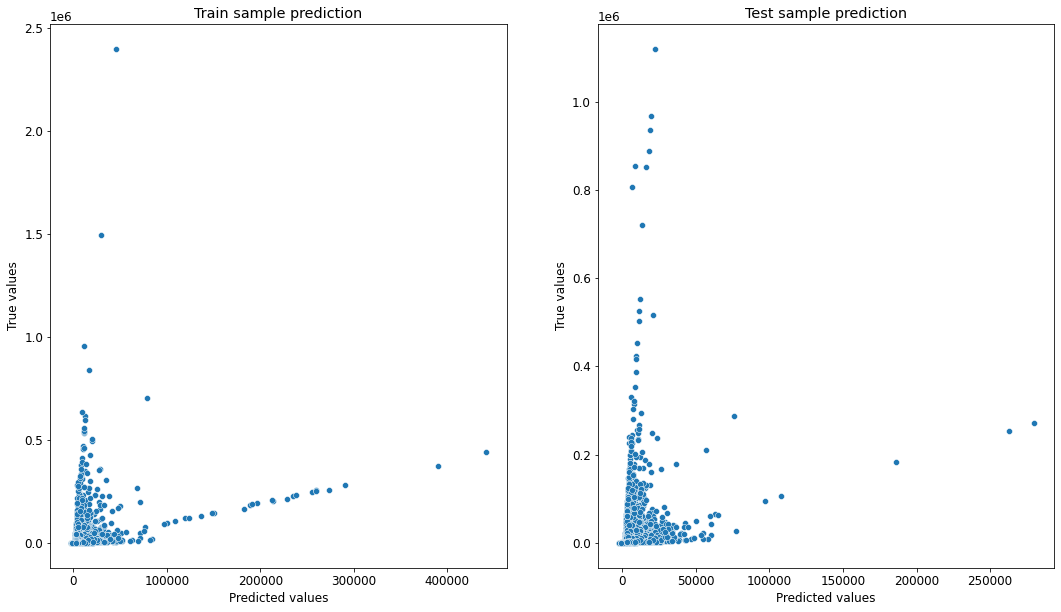

In [506]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)